In [5]:
import logging
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

import hdf5storage
import h5py
import pandas as pd

from replay_trajectory_classification import (SortedSpikesDecoder, ClusterlessDecoder,
                                              SortedSpikesClassifier, ClusterlessClassifier)

from replay_trajectory_classification.state_transition import estimate_movement_var

In [6]:
def load_position(session):
    f = h5py.File(session,'r')
    # load frames [ts x y a s] 
    frames = np.transpose(np.array(f['frames']))
    return pd.DataFrame(frames,columns=['ts', 'x', 'y', 'hd', 'speed'])

def get_spikes(filename):
    data = hdf5storage.loadmat(filename,variable_names=['Spikes'])
    spike_times=data['Spikes']
    spike_times=np.squeeze(spike_times)
    for i in range(spike_times.shape[0]):
        spike_times[i]=np.squeeze(spike_times[i])
    return spike_times

def load_event(session):
    f = h5py.File(session,'r')
    return np.array(f['events'])

data_path = "F:/Projects/PAE_PlaceCell/ProcessedData/"

temp_session = "LEM3206_S20190724151552"
spikes = get_spikes(data_path+temp_session+'.mat')
pos_df = load_position(data_path+temp_session+'.mat')
events = load_event(data_path+temp_session+'.mat')

# limit to epoch

In [7]:
idx = (pos_df.ts > events[0,0]) & (pos_df.ts < events[0,1])
pos_df = pos_df.loc[idx,:]

spikes_restricted = []
for s in spikes:
  spikes_restricted.append(s[(s > events[0,0]) & (s < events[0,1])])

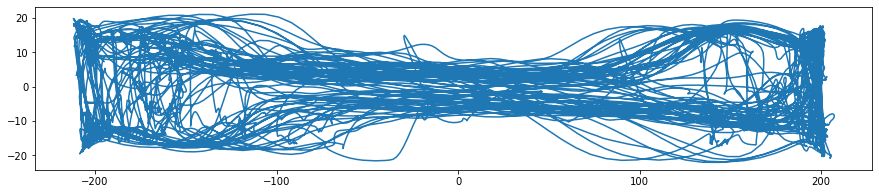

In [27]:
plt.figure(figsize=(15,3))
plt.plot(pos_df.x,pos_df.y)

# Make everyting 1ms bins

In [8]:
# time, position, sampling_frequency, spikes, place_fields = make_simulated_run_data()
sampling_frequency = 1000
time = np.arange(min(pos_df.ts),max(pos_df.ts),1/sampling_frequency)
position = np.interp(time,pos_df.ts,pos_df.x)

In [9]:
def bin_spikes(spike_times,dt,wdw_start,wdw_end):
    """
    Function that puts spikes into bins
    Parameters
    ----------
    spike_times: an array of arrays
        an array of neurons. within each neuron's array is an array containing all the spike times of that neuron
    dt: number (any format)
        size of time bins
    wdw_start: number (any format)
        the start time for putting spikes in bins
    wdw_end: number (any format)
        the end time for putting spikes in bins
    Returns
    -------
    neural_data: a matrix of size "number of time bins" x "number of neurons"
        the number of spikes in each time bin for each neuron
    """
    edges=np.arange(wdw_start,wdw_end,dt) #Get edges of time bins
    num_bins=edges.shape[0]-1 #Number of bins
    num_neurons=spike_times.shape[0] #Number of neurons
    neural_data=np.empty([num_bins,num_neurons]) #Initialize array for binned neural data
    #Count number of spikes in each bin for each neuron, and put in array
    for i in range(num_neurons):
        neural_data[:,i]=np.histogram(spike_times[i],edges)[0]
    return neural_data

spikes = bin_spikes(np.array(spikes_restricted),1/sampling_frequency,min(pos_df.ts),max(pos_df.ts)+1/sampling_frequency)
spikes = (spikes > 0)*1

(100.0, 120.0)

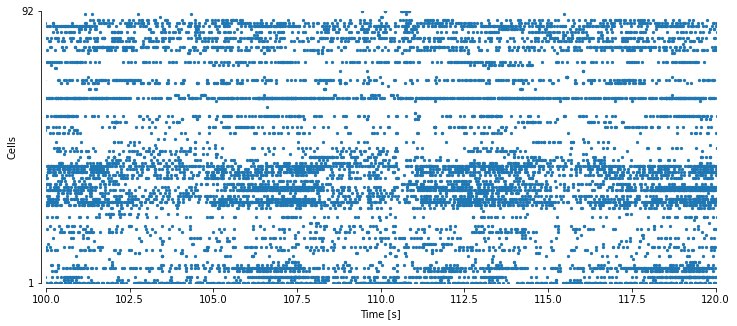

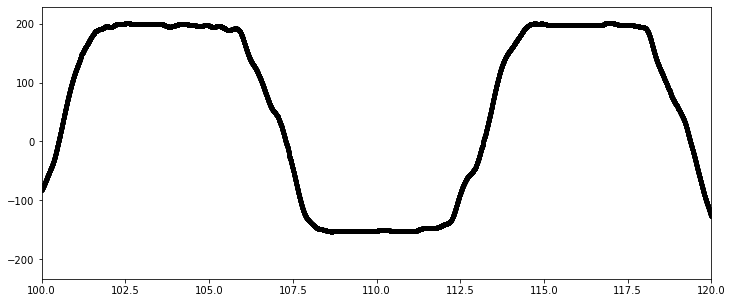

In [12]:
fig, ax = plt.subplots(figsize=(12, 5))
spike_ind, neuron_ind = np.nonzero(spikes)
cmap = plt.get_cmap('tab20')

# c = [cmap.colors[ind] for ind in neuron_ind]
ax.scatter(time[spike_ind], neuron_ind + 1, s=5)
ax.set_yticks((1, spikes.shape[1]))
ax.set_ylim((1, spikes.shape[1]))
ax.set_ylabel('Cells')

ax.set_xlabel('Time [s]')
ax.set_xlim((100.0, 120.0))
sns.despine(offset=5)

fig, ax = plt.subplots(figsize=(12, 5))
plt.plot(time,position,'.k')
ax.set_xlim((100.0, 120.0))

In [17]:
idx_keep = np.logical_not(np.isnan(position))

position = position[idx_keep]
spikes = spikes[idx_keep,:]
time = time[idx_keep]

In [18]:
from dask.distributed import Client

Client(n_workers=2,
       threads_per_worker=2,
       processes=True,
       memory_limit='25GB')

Client Scheduler: tcp://127.0.0.1:51234 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 34.13 GB


In [19]:


movement_var = estimate_movement_var(position, sampling_frequency)

decoder = SortedSpikesDecoder(movement_var=movement_var,
                              replay_speed=1,
                              place_bin_size=np.sqrt(movement_var),
                              knot_spacing=10)
decoder.fit(position, spikes)

INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting place fields...


SortedSpikesDecoder(infer_track_interior=True,
                    initial_conditions_type='uniform_on_track', knot_spacing=10,
                    movement_var=9.656404080908489,
                    place_bin_size=3.107475515737572, position_range=None,
                    replay_speed=1, spike_model_penalty=10.0,
                    transition_type='random_walk')

In [20]:
decoder.place_fields_

<xarray.DataArray (position: 135, neuron: 92)>
array([[0.0545339 , 0.00474578, 0.01693595, ..., 0.00014664, 0.00020274,
        0.00026113],
       [0.05067693, 0.00415932, 0.01740437, ..., 0.00015048, 0.00020936,
        0.00024495],
       [0.04752117, 0.0037584 , 0.01699933, ..., 0.00015093, 0.00020593,
        0.00022888],
       ...,
       [0.04183032, 0.00405441, 0.00600425, ..., 0.00013049, 0.00025297,
        0.00027823],
       [0.0508422 , 0.00485419, 0.00694721, ..., 0.00013633, 0.00023632,
        0.0003438 ],
       [0.06449313, 0.00589413, 0.0081871 , ..., 0.00014367, 0.00020295,
        0.00043837]])
Coordinates:
  * position  (position) float64 -210.4 -207.3 -204.2 ... 199.4 202.5 205.6
Dimensions without coordinates: neuron

NameError: name 'place_fields' is not defined

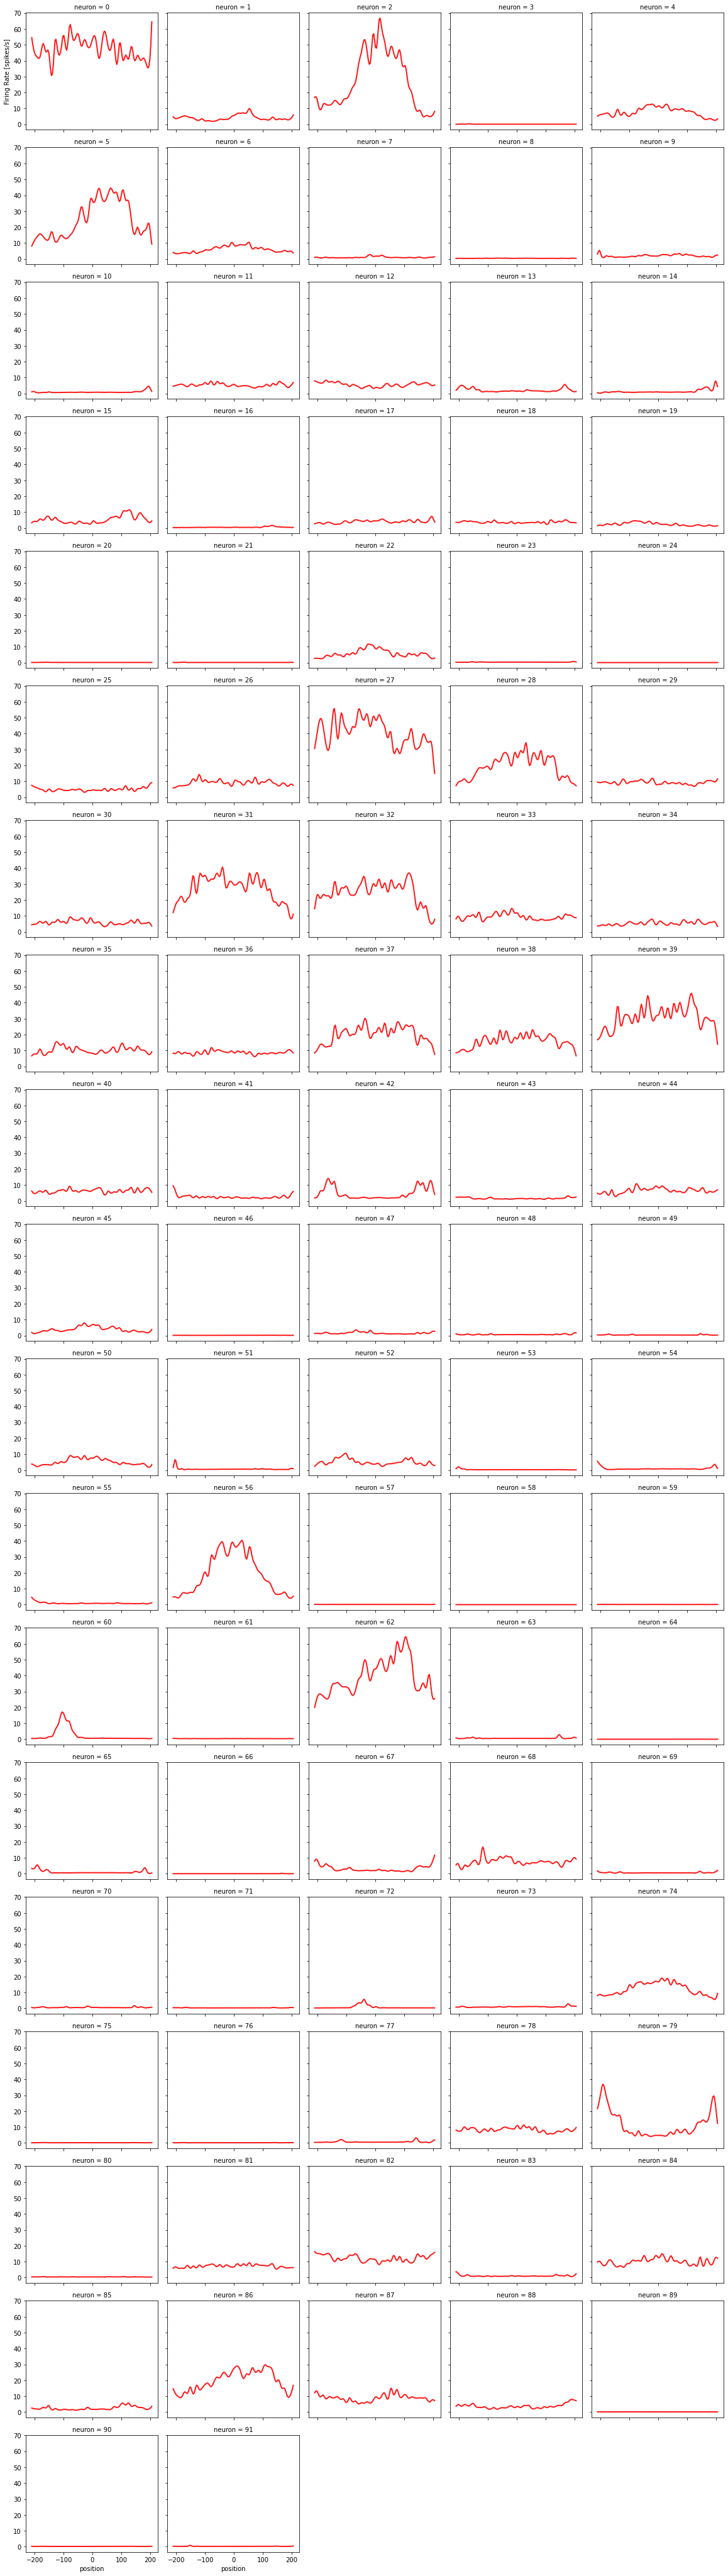

In [21]:
g = (decoder.place_fields_ * sampling_frequency).plot(
        x="position", col="neuron", col_wrap=5, color="red", linewidth=2, alpha=0.9, zorder=1, label="Predicted")
g.axes[0, 0].set_ylabel("Firing Rate [spikes/s]")
for ax, place_field in zip(g.axes.flat, place_fields.T):
    ax.plot(position, place_field, linewidth=2, color="black", zorder=-1, label="True")
sns.despine()

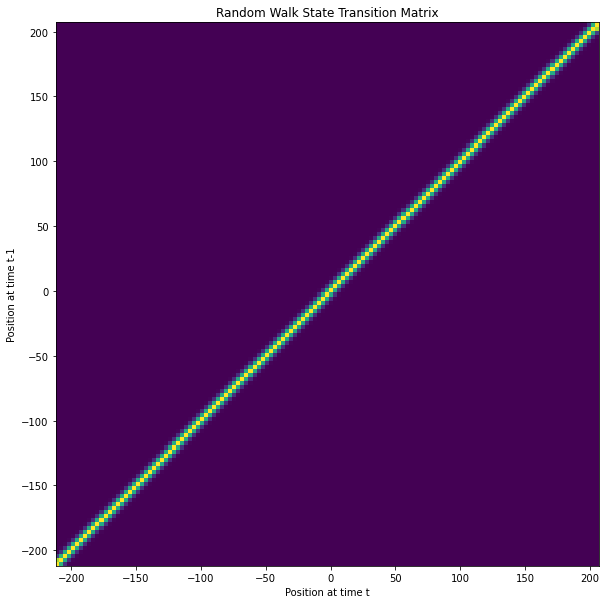

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

edge1, edge2 = np.meshgrid(decoder.place_bin_edges_, decoder.place_bin_edges_)
ax.pcolormesh(edge1, edge2, decoder.state_transition_.T, vmin=0.0, vmax=np.percentile(decoder.state_transition_, 99.9))
ax.set_title("Random Walk State Transition Matrix")
ax.set_ylabel("Position at time t-1")
ax.set_xlabel("Position at time t")
ax.axis("square");

In [23]:
time_ind = slice(0, 50000)

results = decoder.predict(spikes[time_ind], time=time[time_ind])
results

<xarray.Dataset>
Dimensions:            (position: 135, time: 50000)
Coordinates:
  * time               (time) float64 71.9 71.91 71.91 ... 121.9 121.9 121.9
  * position           (position) float64 -210.4 -207.3 -204.2 ... 202.5 205.6
Data variables:
    likelihood         (time, position) float64 0.9891 0.9741 ... 1.0 0.9994
    causal_posterior   (time, position) float64 0.00844 0.008311 ... 2.777e-16
    acausal_posterior  (time, position) float64 0.01015 0.01371 ... 2.777e-16

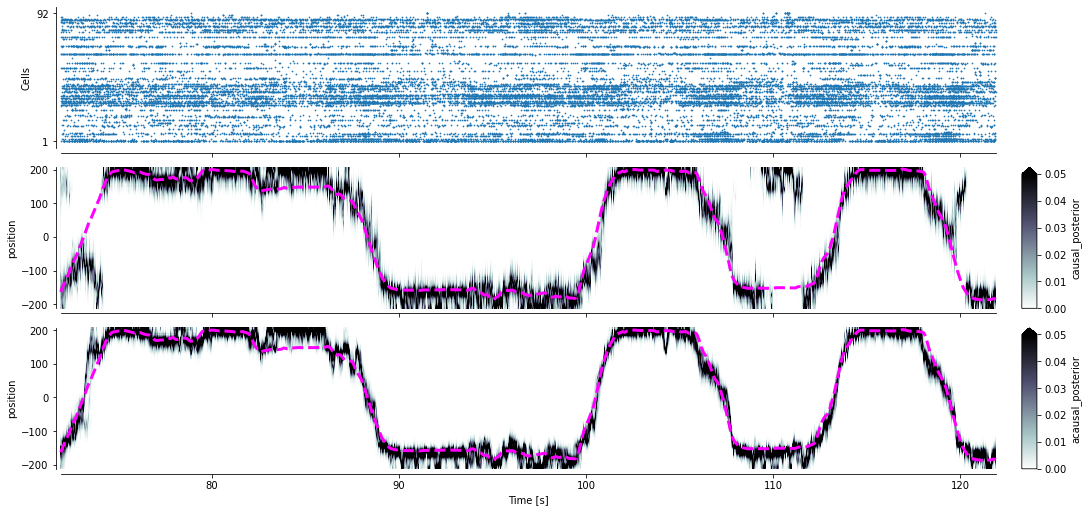

In [25]:
fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15, 7))

spike_ind, neuron_ind = np.nonzero(spikes[time_ind])
# c = [cmap.colors[ind] for ind in neuron_ind]
axes[0].scatter(time[spike_ind], neuron_ind + 1, s=0.5, clip_on=False)
axes[0].set_yticks((1, spikes.shape[1]))
axes[0].set_ylabel('Cells')

results.causal_posterior.plot(x="time", y="position", ax=axes[1], cmap="bone_r", vmin=0.0, vmax=0.05, clip_on=False)
axes[1].plot(time[time_ind], position[time_ind], color="magenta", linestyle="--", linewidth=3, clip_on=False)
axes[1].set_xlabel("")
results.acausal_posterior.plot(x="time", y="position", ax=axes[2], cmap="bone_r", vmin=0.0, vmax=0.05, clip_on=False)
axes[2].plot(time[time_ind], position[time_ind], color="magenta", linestyle="--", linewidth=3, clip_on=False)
axes[2].set_xlabel('Time [s]')
sns.despine(offset=5)